In [1]:
import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
import glob
import torch
from torchvision import transforms
import cv2
from imageio import imread, imsave
from skimage.transform import resize

from endo_sfm.utils import tensor2array

from endo_sfm.models_def.DispResNet import DispResNet


In [2]:
# Path to RGB image
input_path = "data/sim_data/SimData14_train/Scene_00003/RGB_Frames/000008.png"

#Read the input images
input_image = pil.open(input_path).convert('RGB')


In [3]:
# Load depth model


device =  torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
resnet_layers = 18
model_img_height = 320
model_img_width = 320

disp_net = DispResNet(resnet_layers, False).to(device)
disp_net.eval()


pretrained_weights_path = "saved_models/EndoSFM_orig/dispnet_model_best.pth.tar"
weights = torch.load(pretrained_weights_path)
disp_net.load_state_dict(weights["state_dict"])
disp_net.eval()

DispResNet(
  (encoder): ResnetEncoder(
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): 

In [4]:
# Run depth prediction


img = imread(input_path).astype(np.float32)

h, w, _ = img.shape
if (h != model_img_height or w != model_img_width):
    img = resize(img, output_shape=(model_img_height, model_img_width)).astype(np.float32)
img = np.transpose(img, (2, 0, 1))

tensor_img = torch.t(img).unsqueeze(0)
tensor_img = ((tensor_img / 255 - 0.45) / 0.225).to(device)

with torch.no_grad():
    output = disp_net(tensor_img)[0] # take the first output (full scale image)
    
#  Depth is the inverse of disparity
depth = 1 / output
depth = depth.squeeze().cpu().numpy()



print(depth.shape)

/tmp/ipykernel_1503743/2711207562.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(input_path).astype(np.float32)


(320, 320)


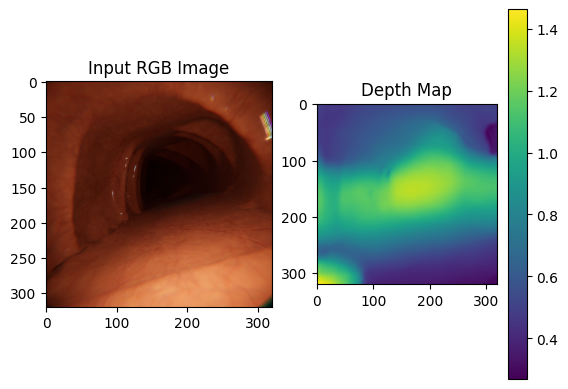

In [5]:
# Plots

plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Input RGB Image")

plt.subplot(1, 2, 2)
plt.imshow(depth)
plt.colorbar()
plt.title("Depth Map")

plt.show()

